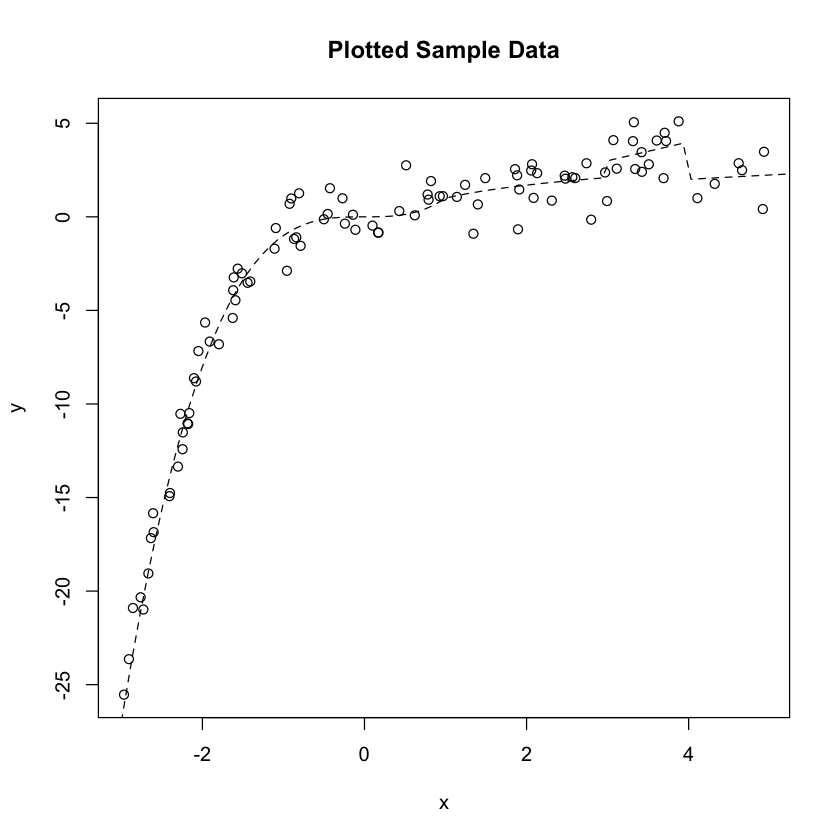

In [32]:
# generate some data
set.seed(34243411) 
n <- 100
from <- -3
to <- 5
x <- runif(n, from, to)
mu <- function(x) {
    id <- x > 1 & x < 3
    id.comp <- x<=1 
    x[id] <- log(x[id]) + 1
    x[id.comp] <- x[id.comp]^3
    id2 <- x > 4
    x[id2] <- sqrt(x[id2])
    return(x)
}
resids <- function(n) {rnorm(n,0,1)} 

y <- mu(x) + resids(n)
plot(x,y, main='Plotted Sample Data')
funx <- seq(from = min(x)-1, to=max(x)+1, length.out = 100)
lines(funx, mu(funx), lty=2, )

# General linear regression and finding basis vectors

In [3]:
m1 <- lm(y ~ x)
solve(t(x) %*% x) 

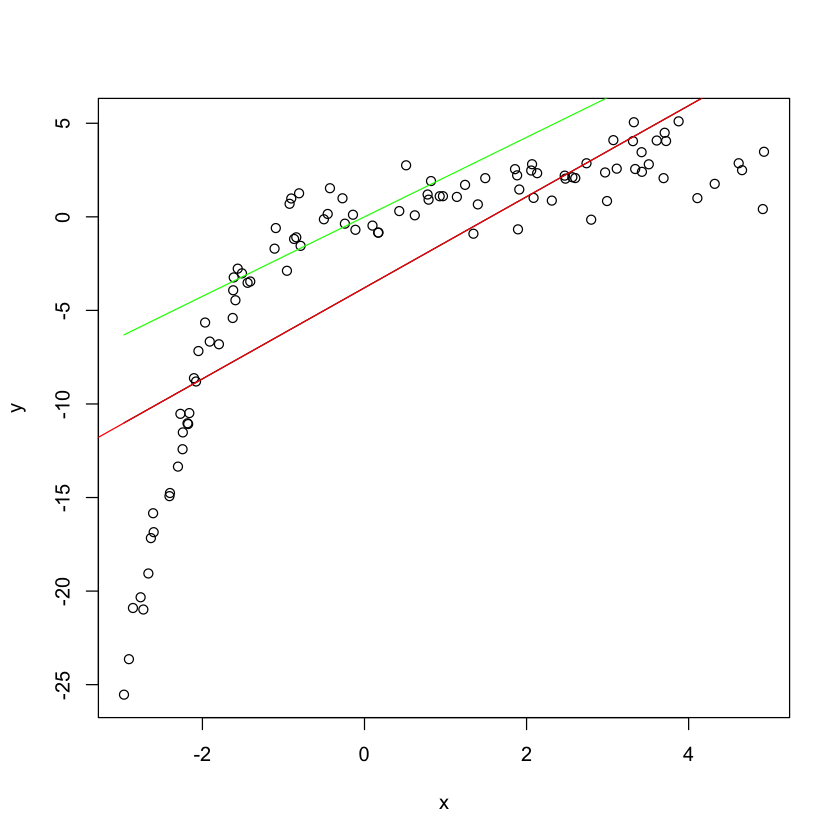

In [60]:
plot(x,y)
X <- t(rbind(rep(1, length(x)), x))

H <- X %*% solve(t(X) %*% X) %*% t(X)
lines(x, H %*% y)
h <- x %*% solve(t(x) %*% x) %*% t(x)
lines(x, h %*% y, col='green')
lines(funx, predict(lm(y ~ x), data.frame(x=funx)), col='red')

So we can see that each curve fit is some fancy form of least squares 
$$ Hy = \hat{u(x)} $$ 

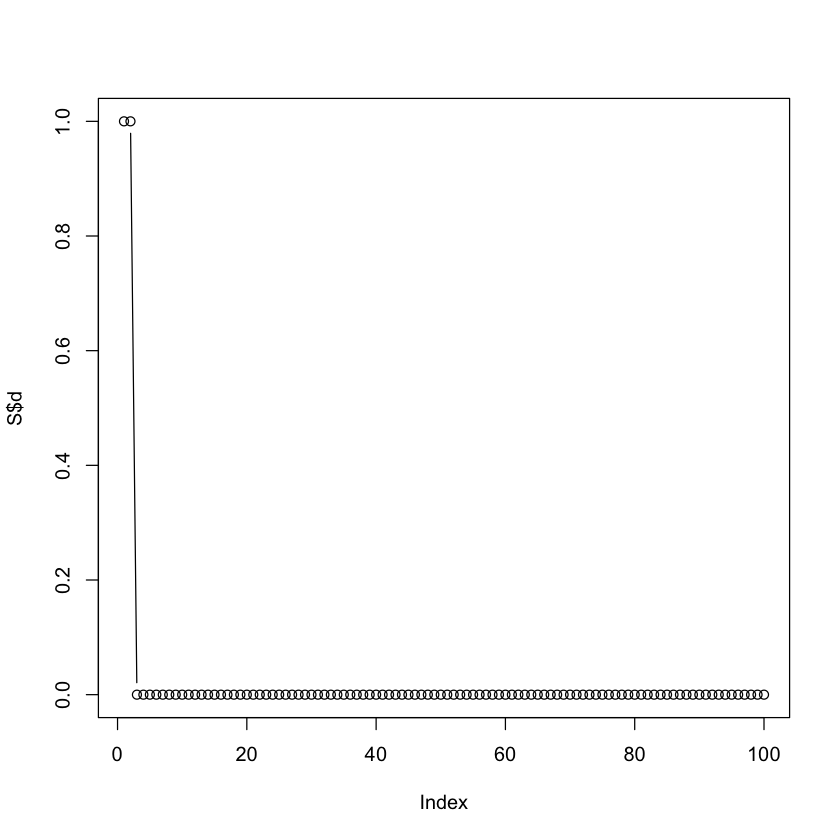

[1] 2

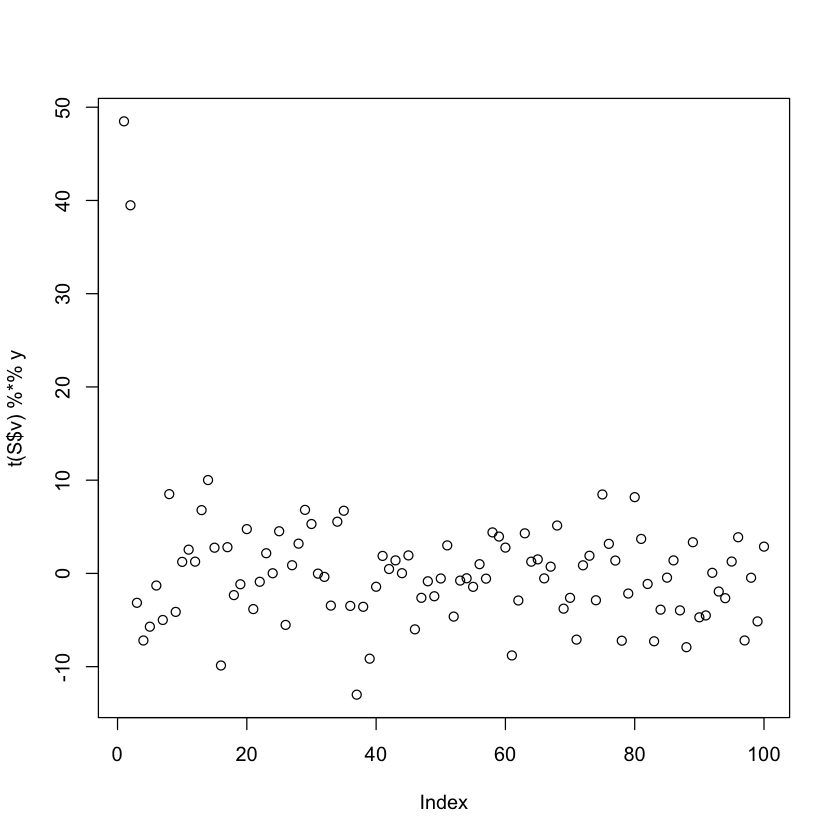

In [68]:
# number of 
S <- svd(H)
plot(S$d, type='b')
plot(t(S$v) %*% y)
sum(S$d)

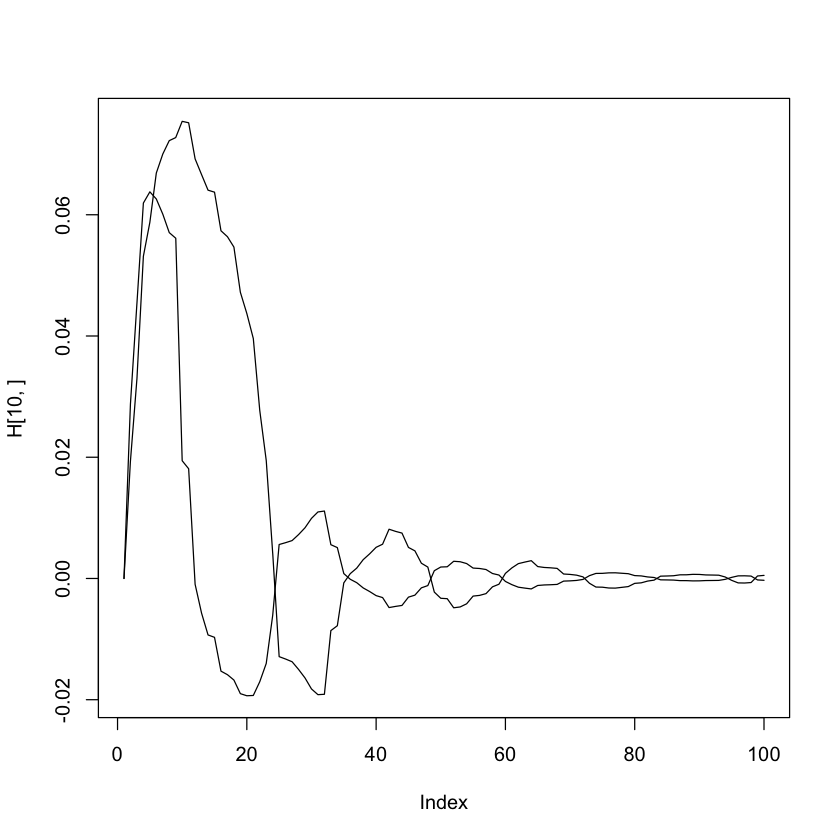

In [137]:
plot(H[10,], type='l')
lines(H[2,])

# P-Splines

We know the model for a p-degree spline is:

$$ \hat{u(x)} = \sum_{j=1}^{J} \hat{u_j{(x)}} \\$$

We also know that

$$ \hat{u(x)} = H_b y $$
$$ H_b = B(B^T B)^{-1} B^T $$

In [70]:
library(splines)

Warning message:
In bs(x, degree = 3L, knots = structure(c(-2.26161452638917, -1.62185584474355, : some 'x' values beyond boundary knots may cause ill-conditioned bases

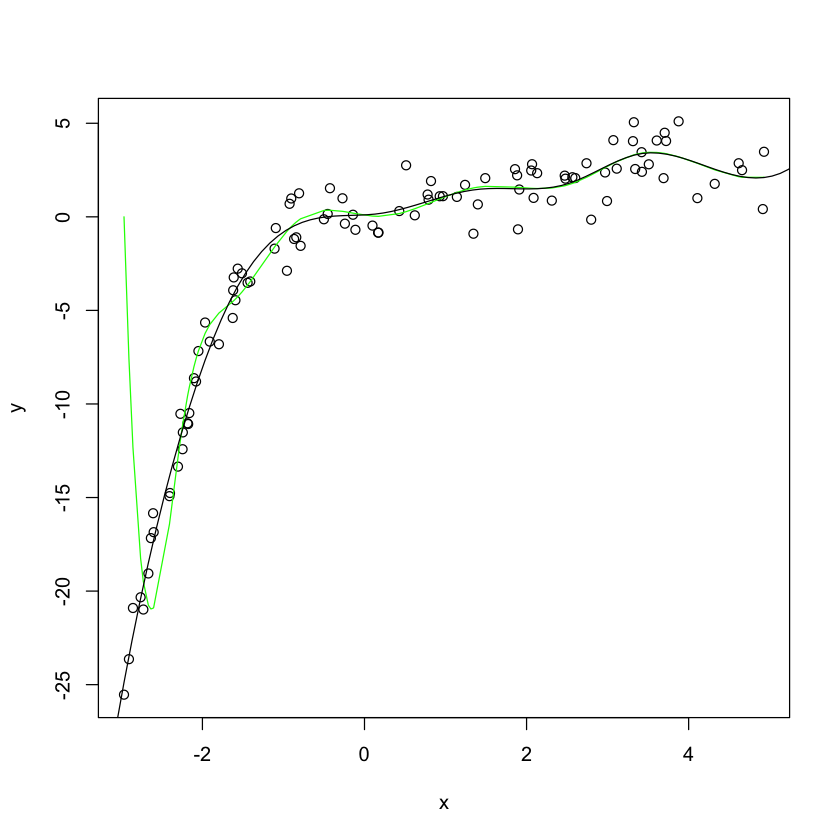

In [121]:
Xorder <- order(x)
B <- bs(x[Xorder], degree = 3, df = 10 )# 7 knots
H <- B %*% solve(t(B) %*% B) %*% t(B)
plot(x,y)
# close enough!
lines(x[Xorder], H %*% y[Xorder], col='green')
lines(funx, predict(lm(y ~ bs(x, degree = 3, df = 10 )), data.frame(x=funx)))

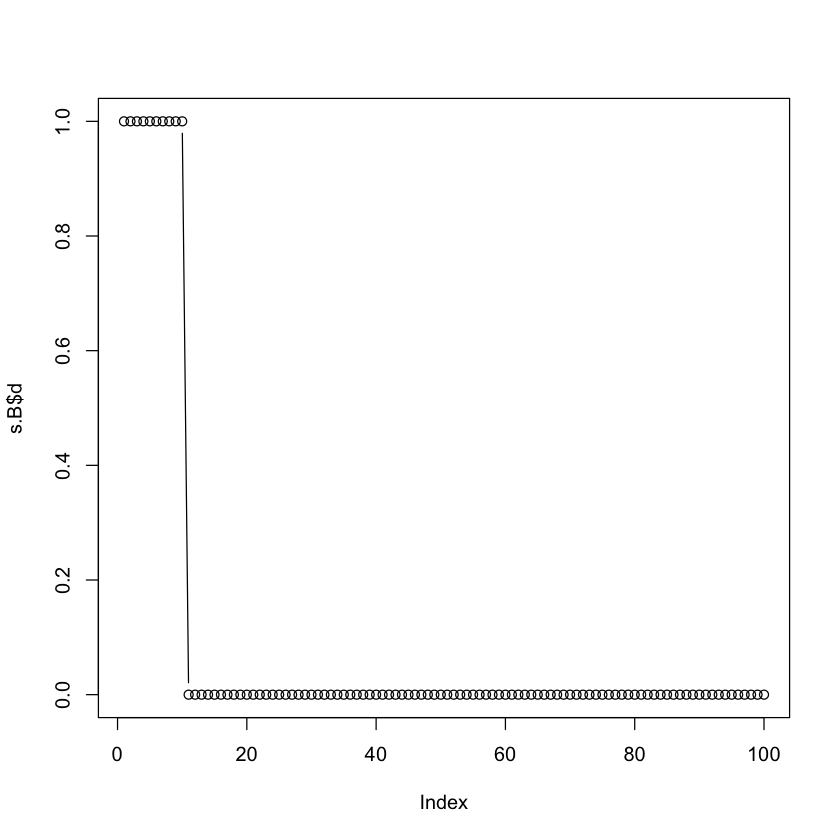

[1] 10

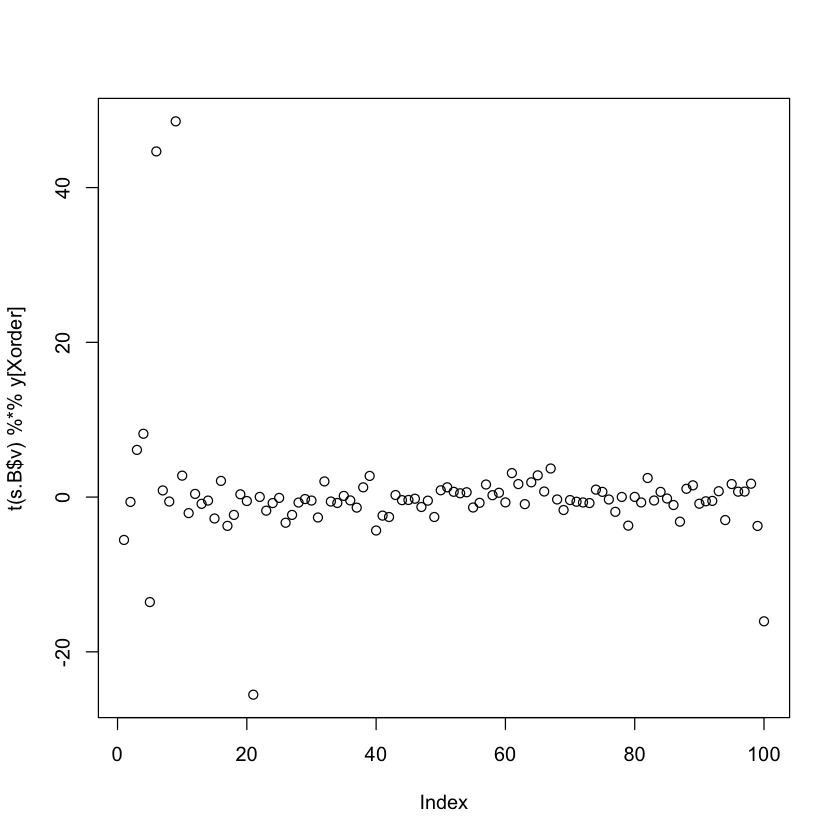

In [88]:
s.B<- svd(H)

plot(s.B$d, type='b')
plot(t(s.B$v) %*% y[Xorder])
sum(s.B$d)

# Smoothing Function

In [90]:
smootherMatrix <- function(x,df) { n <- length(x)
    S <- matrix(0, n, n)
    for (i in 1:n) {
        ei = rep(0, n)
        ei[i] <- 1
        # insert the fit into the i'th column of S
        S[,i] <- predict(smooth.spline(x, ei, df=df), x)$y
    }
      # To make sure the result is (numerically) symmetric
    S <- (S + t(S))/2
    # and return the symmetric matrix S
    return(S)
}


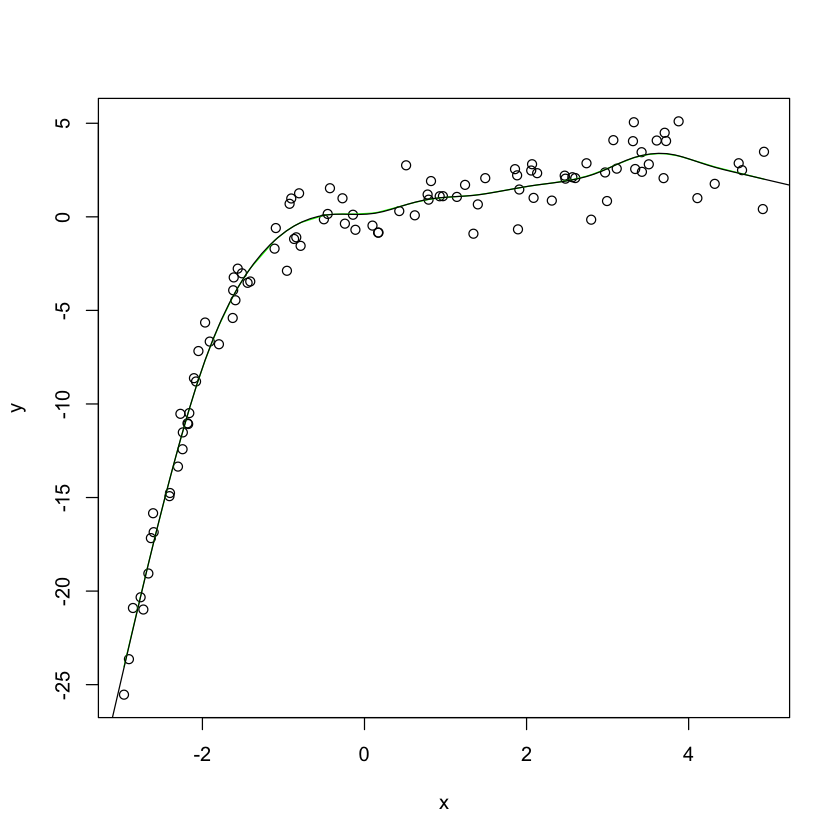

In [100]:
Sy <- smootherMatrix(x[Xorder], 10)
plot(x,y)
lines(x[Xorder], Sy %*% y[Xorder], col='green')
lines(funx, predict(smooth.spline(x=x, y=y), funx)$y)

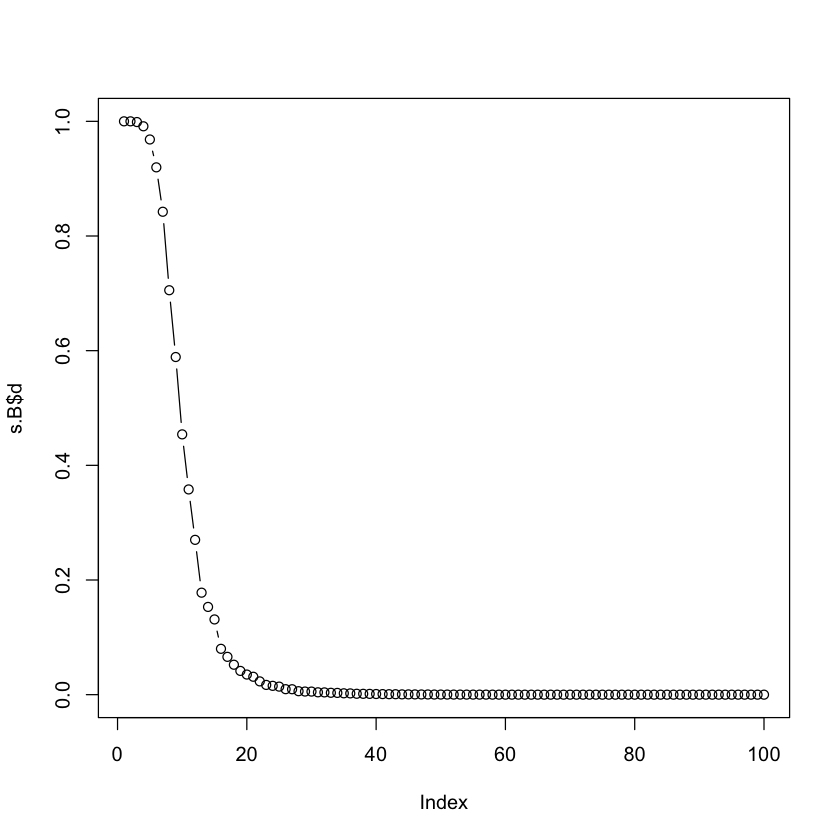

[1] 10.00131

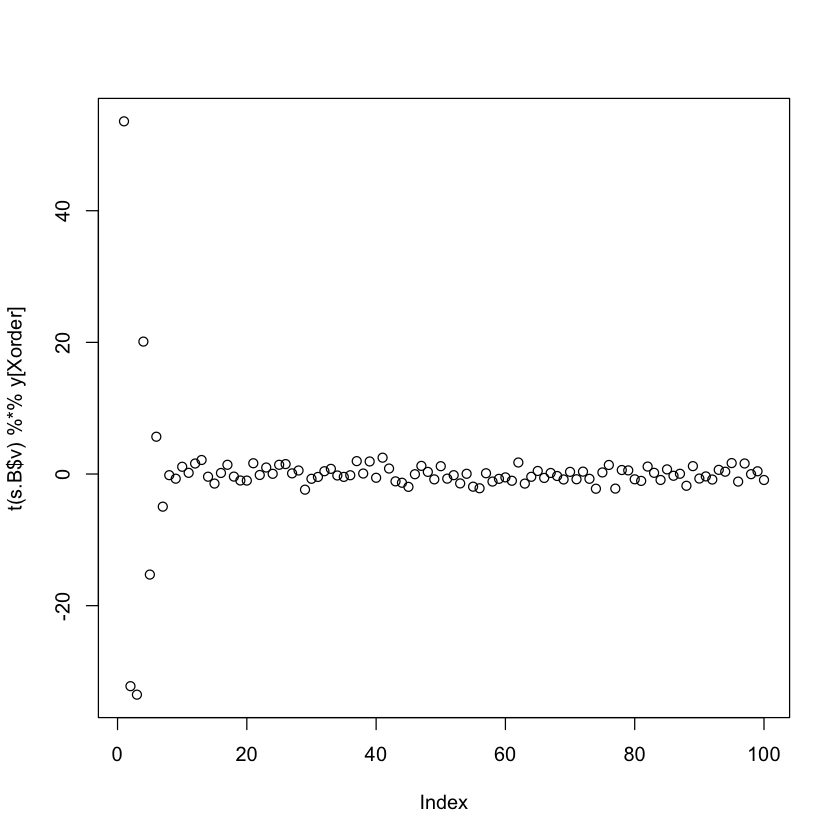

In [127]:
s.B<- svd(Sy)

plot(s.B$d, type='b')
plot(t(s.B$v) %*% y[Xorder])
sum(s.B$d)

# Local Smoothing Matrix

In [103]:
smootherMatrixLoess <- function(x,
                                span=NULL,
                                enp.target=NULL,
                                ...) {
    n <- length(x)
    S <- matrix(0, n, n) 
    for (i in 1:n) {
        ei = rep(0, n)
        ei[i] <- 1
        # insert the fit into the i'th column of S 
        if (is.null(span) & is.null(enp.target)) {
            S[,i] <- predict(loess(ei ~ x, ...)) 
        } else {
            if (is.null(span)) {
                S[,i] <- predict(loess(ei ~ x,enp.target=enp.target,...))
            } else {
                S[,i] <- predict(loess(ei ~ x,span=span,...))
            } 
        }
        
    }
    # For loess, the smoother matrix need # not be a symmetric matrix
    S
}

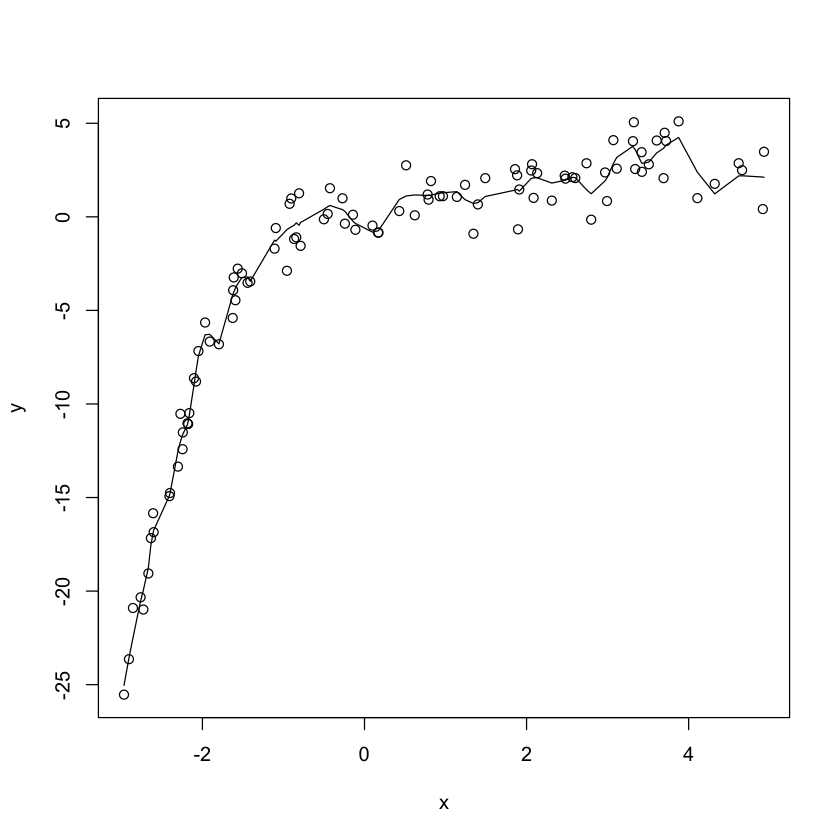

In [125]:
Sym <- smootherMatrixLoess(x[Xorder],span=0.1)
plot(x,y)
lines(x[Xorder], Sym %*% y[Xorder])

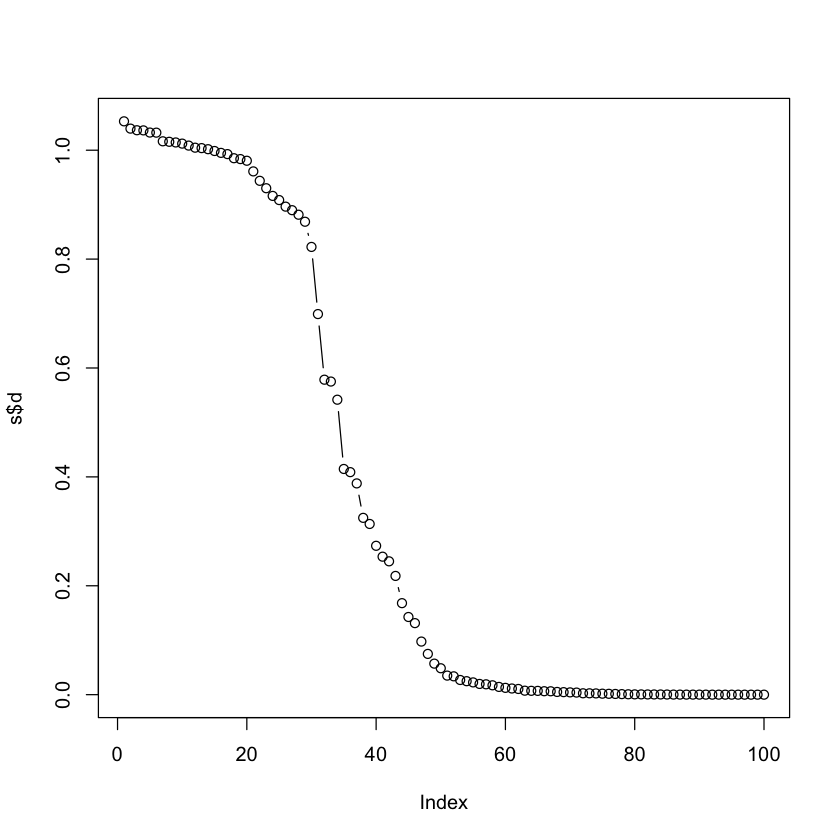

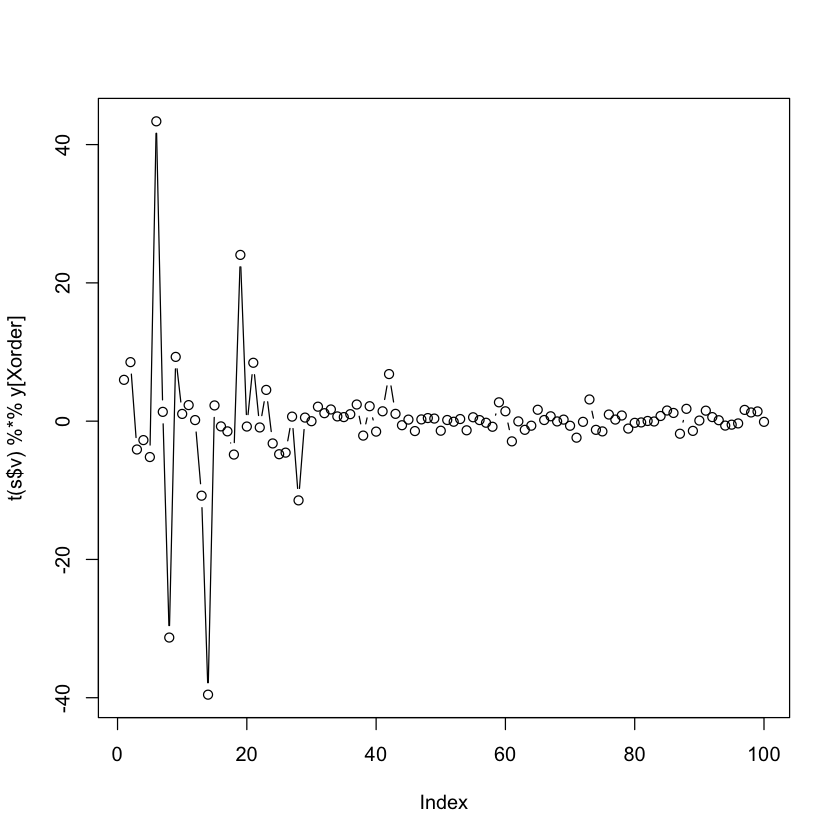

In [126]:
s <- svd(Sym)
plot(s$d, type='b')
plot(t(s$v) %*% y[Xorder], type='b')

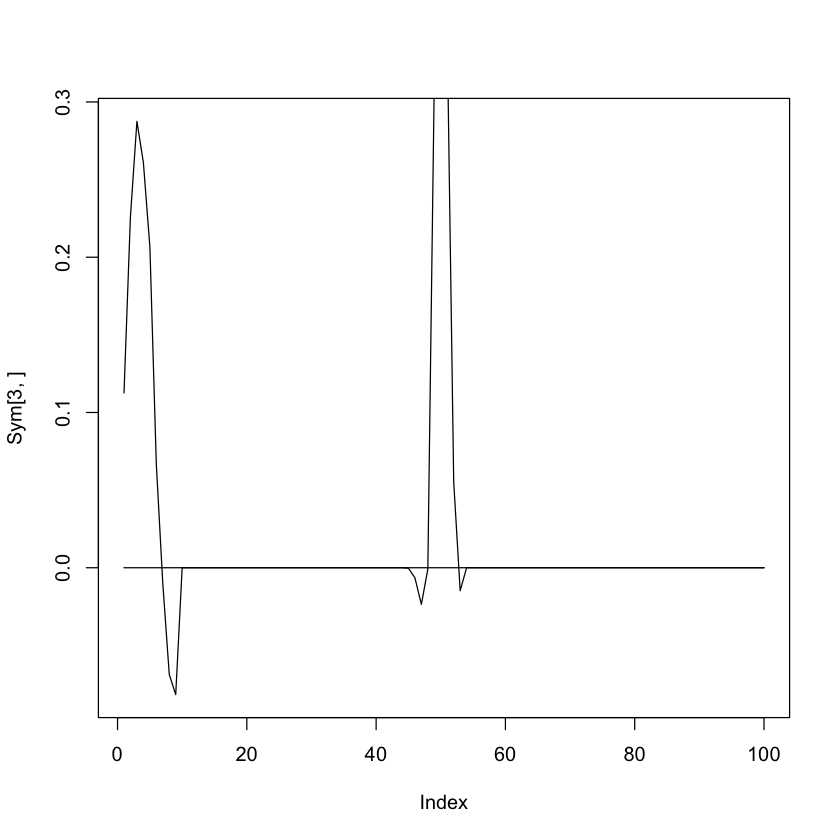

In [142]:
plot(Sym[3,], type='l')
lines(Sym[50,])
